
- PTBR: 

    Você trabalha em uma consultoria de dados que foi contratada para realizar a distribuição de materiais didáticos nas escolas da cidade do Rio de Janeiro. Sua missão é realizar tratamentos nos dados de acordo com as normas de padrão definidas pelo cliente e encontrar qual a melhor rota que um caminhão deve realizar para entregar os materiais didáticos de forma a otimizar o seu percurso. 

    Para esse projeto você recebeu três arquivos: 

    escolas.csv: contém os dados das escolas. Baixe o dataset aqui;
    subprefeituras.csv: contém dados de quais bairros pertem a cada subprefeitura. Baixe o dataset aqui;
    material_didatico.csv: contém a quantidade de material didático que cada escola deve receber. Baixe o dataset aqui.
    Como produto final, você deve entregar: 

    um arquivo csv no qual as linhas já estarão ordenas de acordo com a rota a ser seguida. Além disso, os dados devem estar no padrão especificado abaixo e contendo as seguintes colunas: id da escola, nome da escola, tipo da escola (EM, CIEP ou colégio), logradouro da entrega, número, bairro, subprefeitura, latitude, longitude e quantidade de mat erial didático que deve ser entregue. O logradouro da escola deve estar em uma coluna diferente do número; 
    um arquivo csv com a quantidade total de material escolar por subprefeitura para que sejam contabilizados os custos por subprefeitura 
    Como padrão dos dados, considere:

    nome das colunas em snake_case
    strings não devem conter acentos
    todas as strings devem estar em maiúsculo
    padronização do nome dos logradouros sem abreviação (Ex: R. deve estar como Rua)
    latitude e longitude devem conter apenas 5 casas decimais
    os ids da escola devem todos ser strings com 3 caracteres (Ex: '024')
    Desafio: Entregar um plot com a representação da melhor rota que você encontrou
 ---
- EN:

    You work at a data consultancy firm that has been hired to manage the distribution of educational materials to schools in the city of Rio de Janeiro. Your mission is to process the data according to the standard norms set by the client and determine the most efficient route for a truck to deliver the educational materials, optimizing its journey.

    For this project, you received three files:

    schools.csv: contains the data of the schools. Download the dataset here.
    subprefectures.csv: contains data on which neighborhoods belong to each subprefecture. Download the dataset here.
    educational_material.csv: provides the quantity of educational materials that each school should receive. Download the dataset here.
    As a final deliverable, you should provide:

    A CSV file in which the rows are already sorted according to the route to be followed. Additionally, the data should follow the specified standard below and contain the following columns: school id, school name, school type (EM, CIEP, or college), delivery address, number, neighborhood, subprefecture, latitude, longitude, and quantity of educational material to be delivered. The school's address should be in a column separate from the number.
    A CSV file with the total quantity of school materials per subprefecture, so the costs per subprefecture can be accounted for.
    Regarding data standards, consider:

    Column names in snake_case.
    Strings should not contain accents.
    All strings should be in uppercase.
    Standardization of street names without abbreviations (e.g., "R." should read as "Street").
    Latitude and longitude should only contain 5 decimal places.
    All school IDs should be strings with 3 characters (e.g., '024').
    Challenge: Deliver a plot illustrating the best route you've determined.

# Overall checklist

- [x] Checklist related to in-row formatting
- [x] Checklist related to best route
- [x] Checklist related to the new dataset
- [x] Checklist related to plot illustrating the best route

# My idea for the challenge

----
#### About the Challenge:

-- IMPORTANT: The problem is straightforward to solve; however, I pursued an approach designed for cases that lack a simple resolution, akin to what we encounter with longitude, in an effort to learn. My solution achieved approximately a 96% accuracy. This is my first attempt at this kind of problem --

- I make a consideration of a symmetric distance matrix, with N^2 calculations, and store it (we could use divide and conquer, assuming a larger dataset, while maintaining at least reasonable handling).

- I find the pair with the smallest distance to ensure the initialization of the smallest pair of points (MIN value).

- Now, I search for the MIN again for each pair of values and find the starting point, such as coord[Y, X], to create a new coordinate coord_new[(Y or X), Z], always removing it from the list if I have already found it previously to avoid recalculations in larger orders.

- The result is a list of values containing all the pairs, stored in temporary memory.

- I will use the ID data from temporary memory, with the logic applied earlier, to organize the schools in the order to be traversed.

#### Considerations about "intentional" data cleaning "issues":

- I will not validate the data type in the columns before processing.
- I will perform all cleaning grouped by the type of checklist usage.
- When not applicable, I will perform treatments for checklists with different approaches.
- Some treatments are duplicated.

In [15]:
import pandas as pd
import os
import re
from unidecode import unidecode
from geopy.distance import geodesic
import cProfile
import networkx as nx
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

In [16]:
# loading our csvs


escolas = pd.read_csv('csv_raw/escolas.csv')
material_didatico = pd.read_csv('csv_raw/material_didatico.csv')
subprefeituras = pd.read_csv('csv_raw/subprefeituras.csv')

In [17]:
# utils


def to_snake_case(s):
    s = unidecode(s).upper()
    s = re.sub(r'[\W_]+', ' ', s)  # replace non-alphanumeric characters and underscores with spaces
    s = s.strip().replace(' ', '_')
    return s

def extract_street_number(address):
    parts = address.split()
    if parts:
        return parts[-1]
    else:
        return 0

def remove_special_characters(text):
    text_without_special_chars = re.sub(r'[^\w\s]', '', text)
    return text_without_special_chars

def find_abbreviations(df, column_name):
    seen_abbreviations = set()
    results = []

    # Extract abbreviations from the specified column
    abbreviations = df[column_name].astype(str).str.extract(r'(^\w+\.)')[0]

    # Drop NaN rows and duplicate abbreviations
    abbreviations = abbreviations.dropna().drop_duplicates()

    # Filter out abbreviations that have already been seen
    abbreviations = abbreviations[~abbreviations.isin(seen_abbreviations)]

    if not abbreviations.empty:
        for abb in abbreviations:
            # Display abbreviation alongside the original string
            original_string = df[df[column_name].astype(str).str.startswith(abb)].iloc[0][column_name]
            results.append((abb, original_string))
            seen_abbreviations.add(abb)

    return results

def is_alphanumeric(value):
    return bool(re.match("^[a-zA-Z0-9]*$", value))

def extract_number_or_sno(address):
    last_word = address.split()[-1]
    return last_word if is_alphanumeric(last_word) and not last_word.isalpha() else 'SNo'


In [18]:
# preview


print(f'escolas.csv: \n{escolas.head()}\n')
print('-'*32)
print(f'material_didatico.csv: \n{material_didatico.head()}\n')
print('-'*32)
print(f'subprefeituras.csv: \n{subprefeituras.head()}\n')

escolas.csv: 
    id                               Escolas_Postos         BAIRRO  \
0  178  CENTRO INTEGRADO DE EDUCAÇÃO PÚBLICA HENFIL           CAJU   
1  634                   EM ALICE DO AMARAL PEIXOTO        BENFICA   
2  483                           EM CELESTINO SILVA         CENTRO   
3  476            ESCOLA MUNICIPAL FLORIANO PEIXOTO  SÃO CRISTÓVÃO   
4  132                            EM PEREIRA PASSOS   RIO COMPRIDO   

                            ENDEREÇO          lat         lon  
0               Rua Carlos Seidl S/Nº  -22,880888  -43,225326  
1                       Rua Ébano 187  -22,889574  -43,236202  
2                  R. do Lavradio, 56  -22,909293  -43,183579  
3                  Praça Argentina 20  -22,897629  -43,227456  
4  Praça Condessa Paulo de Frontin 45  -22,924412  -43,208579  

--------------------------------
material_didatico.csv: 
    id Quantidade
0  178         20
1  634        121
2  483        220
3  476        190
4  132         67

--------------

In [19]:
# Removing duplicates to reduce redundancies


duplicates = escolas[escolas.duplicated(subset=[column for column in escolas.columns])].shape[0]
print(f'Duplicates in our df: {duplicates}')

escolas = escolas.drop_duplicates(subset=[column for column in escolas.columns], keep='first')

Duplicates in our df: 13


In [20]:
# Removing duplicates into ID column to reduce redundancies in the school db


duplicates = escolas[escolas.duplicated(subset=['id'])].shape[0]
print(f'Duplicates in our df: {duplicates}')

escolas = escolas.drop_duplicates(subset=['id'], keep='first')

Duplicates in our df: 3


# Checklist related to in-row formatting

- [x] Column names in snake_case
- [x] Strings do not contain accents
- [x] All strings should be in uppercase
- [x] Standardization of street names without abbreviation (E.g.: R. should be Street)
- [x] Latitude and longitude should only have 5 decimal places
- [x] School IDs should all be strings with 3 characters (E.g.: '024')

In [21]:
# converting data in column names to string, removing special characters and string


# material_didatico
escolas.columns = [to_snake_case(col) for col in escolas.columns]

# material_didatico
material_didatico.columns = [to_snake_case(col) for col in material_didatico.columns]

# subprefeituras
subprefeituras.columns = [to_snake_case(col) for col in subprefeituras.columns]

In [31]:
# converting data in specific columns to string, removing special characters and applying upper


# escolas
escolas.update(
    escolas[['ID', 'ESCOLAS_POSTOS', 'BAIRRO', 'ENDERECO']]
    .astype(str)
    .apply(lambda x: x.str.upper())
    .applymap(unidecode)
)

# material_didatico
material_didatico['ID'] = material_didatico['ID'].astype(str).apply(unidecode)

# subprefeituras
subprefeituras['NOME'] = subprefeituras['NOME'].apply(lambda x: unidecode(str(x).upper()))
subprefeituras['SUBPREFEITURA'] = subprefeituras['SUBPREFEITURA'].apply(lambda x: unidecode(str(x).upper()))

In [32]:
escolas

,ID,ESCOLAS_POSTOS,BAIRRO,ENDERECO,LAT,LON
0,178,CENTRO INTEGRADO DE EDUCACAO PUBLICA HENFIL,CAJU,RUA CARLOS SEIDL S/NO,"-22,880888","-43,225326"
1,634,EM ALICE DO AMARAL PEIXOTO,BENFICA,RUA EBANO 187,"-22,889574","-43,236202"
2,483,EM CELESTINO SILVA,CENTRO,"R. DO LAVRADIO, 56","-22,909293","-43,183579"
3,476,ESCOLA MUNICIPAL FLORIANO PEIXOTO,SAO CRISTOVAO,PRACA ARGENTINA 20,"-22,897629","-43,227456"
4,132,EM PEREIRA PASSOS,RIO COMPRIDO,PRACA CONDESSA PAULO DE FRONTIN 45,"-22,924412","-43,208579"
...,...,...,...,...,...,...
146,210,EM DEBORA MENDES DE MORAES,PEDRA DE GUARATIBA,RUA BELCHIOR DA FONSECA 643,"-23,001416","-43,638757"
147,474,EM ENGENHEIRO GASTAO RANGEL,GUARATIBA,ESTRADA DO MAGARCA 9.183,"-22,98046","-43,643545"
148,301,EM JONATAS SERRANO,GUARATIBA,"ESTRADA DO MATO ALTO, S/NO","-22,953163","-43,577409"
149,215,E.M. NARCISA AMALIA,ILHA DE GUARATIBA,ESTRADA TEODORETO DE CAMARGO S/N.O,"-23,009084","-43,537582"


In [33]:
subprefeituras

,NOME,SUBPREFEITURA
0,SANTO CRISTO,CENTRO
1,GAMBOA,CENTRO
2,SAUDE,CENTRO
3,CAJU,CENTRO
4,CENTRO,CENTRO
...,...,...
159,SANTA CRUZ,ZONA OESTE
160,GUARATIBA,ZONA OESTE
161,BARRA DE GUARATIBA,ZONA OESTE
162,PEDRA DE GUARATIBA,ZONA OESTE


* preview, to be able to standardize the name of public places and better understand how they are

In [34]:
# find abbreviations at the ENDERECO Column


abbreviations_found = find_abbreviations(escolas, 'ENDERECO')
for abb, original in abbreviations_found:
    print(f"{abb} from '{original}'")

R. from 'R. DO LAVRADIO, 56'
AV. from 'AV. ATLANTICA, 1976'
PCA. from 'PCA. FREDERICO DUVAL S/NO'
ESTR. from 'ESTR. ADHEMAR BEBIANO 1870'


* now we are able to standardize the address names

In [35]:
# standardize regex pattern to search from the start of the string
# convert all abbreviations to what they actually mean


to_standardize = {
    '^R\.': 'RUA',
    '^AV\.': 'AVENIDA',
    '^PCA\.': 'PRACA',
    '^ESTR\.': 'ESTRADA'
}

column_name = 'ENDERECO'

escolas[column_name] = escolas[column_name].replace(to_standardize , regex=True)

In [36]:
# find abbreviations at the ESCOLAS_POSTOS Column


abbreviations_found = find_abbreviations(escolas, 'ESCOLAS_POSTOS')
for abb, original in abbreviations_found:
    print(f"{abb} from '{original}'")

E. from 'E.M PRESIDENTE JOSE LINHARES'
EM. from 'EM. ENGENHEIRO LAFAYETTE DE ANDRADA'


In [37]:
# removing special characters and standardizing names


column_name = 'ESCOLAS_POSTOS'

escolas[column_name] = escolas[column_name].apply(remove_special_characters)

to_standardize = {
    '^EM ': 'ESCOLA MUNICIPAL ',
    '^E ': 'ESCOLA ',
    'CIEP': 'CENTRO INTEGRADO DE EDUCACAO PUBLICA'
}


escolas[column_name] = escolas[column_name].replace(to_standardize , regex=True)

In [38]:
# Convert 'LAT' and 'LON' columns to float and round to 5 decimal places


escolas['LAT'] = escolas['LAT'].str.replace(',', '.').astype(float).round(5)
escolas['LON'] = escolas['LON'].str.replace(',', '.').astype(float).round(5)

In [39]:
# School IDs should all be strings with 3 characters


escolas['ID'] = escolas['ID'].astype(str).str.zfill(3)

In [40]:
# extract adress number and stores into a new column

escolas['ENDERECO'] = escolas['ENDERECO'].apply(remove_special_characters)

escolas['NUMERO_LOGRADOURO_ENTREGA'] = escolas['ENDERECO'].apply(extract_number_or_sno)

escolas['ENDERECO'] = escolas.apply(lambda row: ' '.join(row['ENDERECO'].split()[:-1]) if row['NUMERO_LOGRADOURO_ENTREGA'] == row['ENDERECO'].split()[-1] else row['ENDERECO'], axis=1)


In [41]:
# preview
escolas.head(5)

,ID,ESCOLAS_POSTOS,BAIRRO,ENDERECO,LAT,LON,NUMERO_LOGRADOURO_ENTREGA
0,178,CENTRO INTEGRADO DE EDUCACAO PUBLICA HENFIL,CAJU,RUA CARLOS SEIDL SNO,-22.88089,-43.22533,SNo
1,634,ESCOLA MUNICIPAL ALICE DO AMARAL PEIXOTO,BENFICA,RUA EBANO,-22.88957,-43.23620,187
2,483,ESCOLA MUNICIPAL CELESTINO SILVA,CENTRO,RUA DO LAVRADIO,-22.90929,-43.18358,56
3,476,ESCOLA MUNICIPAL FLORIANO PEIXOTO,SAO CRISTOVAO,PRACA ARGENTINA,-22.89763,-43.22746,20
4,132,ESCOLA MUNICIPAL PEREIRA PASSOS,RIO COMPRIDO,PRACA CONDESSA PAULO DE FRONTIN,-22.92441,-43.20858,45


# Checklist related to the delivery routes calculus


- [x] Escolha entre o cálculo considerando a terra como um esferoide oblato ou como um círculo perfeito
- [x] Força bruta para definição do ponto de partida.
- [x] Novo cálculo a partir do ponto de partida, combinando com a heurística de Nearest Neighbor + brute force para definição inicial

In [ ]:
# testing if there are latitudes or longitudes out of range
# the other values, we assume as correct.
# if necessary, we could test case by case if necessary (cost for large volumes of data)
# using the Google API and see if the returned address is similar to the address in the address column
# if not, we plan to search for valid addresses and correctly return the lat and lon


lat_out_of_range = escolas[(escolas['LAT'] < -90) | (escolas['LAT'] > 90)]
lon_out_of_range = escolas[(escolas['LON'] < -180) | (escolas['LON'] > 180)]

print("Latitudes fora do intervalo:\n", lat_out_of_range)
print("\nLongitudes fora do intervalo:\n", lon_out_of_range)

In [ ]:
# Checking for duplicates in lat and lon to avoid disturbing our calculations


duplicates = escolas[escolas.duplicated(subset=['LAT', 'LON'])].shape[0]
print(f'Duplicates in our df: {duplicates}')

escolas = escolas.drop_duplicates(subset=['LAT', 'LON'], keep='first')

duplicates = escolas[escolas.duplicated(subset=['LAT', 'LON'])].shape[0]
print(f'After removing them: {duplicates}')

finding the point that I will define as the starting point. I'll use this hard approach with best-pair-comparing later

In [ ]:
from geopy.distance import geodesic

def geodesic_calculus(coord1, coord2):
    if coord1 == coord2:
        return 0.0
    return geodesic(coord1, coord2).km

def calculate_school_distances(escolas):
    distances_calculated = {}
    
    for i, row1 in enumerate(escolas.itertuples(index=True, name='Pandas')):
        coord1 = (row1.LAT, row1.LON)
        id1 = row1.ID
        
        for j, row2 in enumerate(escolas.itertuples(index=True, name='Pandas')):
            
            # redundance
            if i == j:
                continue
            
            coord2 = (row2.LAT, row2.LON)
            id2 = row2.ID
            
            # symmetric calculation: A - > B = A - > B
            if (id1, id2) in distances_calculated:
                distance = distances_calculated[(id1, id2)]
            else:
                distance = geodesic_calculus(coord1, coord2)
                distances_calculated[(id1, id2)] = distance
            
            distances_calculated[(id2, id1)] = distance
    
    return distances_calculated

I've combined everything here to save time on writing the code.

I have another version linked within this same document, but for class testing and validation purposes, I've included everything here in a consolidated form.

In [ ]:
def visualize_route(distances_calculated, route_so_far, current_school):
    G = nx.Graph()

    # Adding nodes and edges to the graph

    for (school1, school2), distance in distances_calculated.items():
        G.add_edge(school1, school2, weight=distance)

    pos = nx.spring_layout(G)

    plt.clf()

    nx.draw_networkx_nodes(G, pos)

    nx.draw_networkx_nodes(G, pos, nodelist=route_so_far, node_color='y', label="Visited")

    nx.draw_networkx_nodes(G, pos, nodelist=[current_school], node_color='g', label="Current")

    nx.draw_networkx_edges(G, pos, alpha=0.2)

    for i in range(len(route_so_far) - 1):
        nx.draw_networkx_edges(G, pos, edgelist=[(route_so_far[i], route_so_far[i+1])], edge_color='r', width=2)

    nx.draw_networkx_labels(G, pos)

    plt.legend()

    plt.draw()
    plt.pause(0.01)

def find_optimal_route_with_visualization(distances_calculated):
    '''
    This function aims to find the optimal route among several schools by utilizing
    the Nearest Neighbor algorithm, after the first approach is applied.
    1 - I create a dictionary of adjacent schools with their corresponding distances, sorted in ascending order.
    2 - Then I select the pair of schools with the shortest distance between them to start the route.
    3 - I initialize sets to keep track of the schools already visited and the route so far.
    4 - As long as not all schools have been visited, I continue to search for the nearest
    adjacent school that hasn't been visited yet.
    5 - In the end, I visualize the complete route in a graph.

    distances_calculated: I'm returning a dictionary containing pairs of schools and their respective distances.
    route: I'm returning a list representing the order of school visits. 
    In this case, I tried to optimize the code a little, by explicitly passing the data type, to avoid Python
    to search automatically
    
    I also had some loops and changed them all to list comprehension,
    in order to gain more performance
    '''
    sorted_distances = sorted(distances_calculated.items(), key=lambda item: item[1])

    adjacent_schools: Dict[str, List[Tuple[str, float]]] = {
        school: [
            (pair[0] if pair[1] == school else pair[1], distance) for pair, distance in sorted_distances if school in pair
        ]
        for school in {pair[0] for pair in distances_calculated.keys()}.union(
            {pair[1] for pair in distances_calculated.keys()}
        )
    }

    starting_pair: Tuple[str, str] = min(
        distances_calculated,
        key=distances_calculated.get
    )

    route: List[str] = [starting_pair[0], starting_pair[1]]
    visited: set = {starting_pair[0], starting_pair[1]}
    current_school: str = starting_pair[1]

    plt.figure(figsize=(10, 6))
    
    total_schools = len(adjacent_schools)
    while len(visited) < total_schools:
        visualize_route(distances_calculated, route, current_school)
        found = False
        for next_school, _ in adjacent_schools[current_school]:
            if next_school not in visited:
                route.append(next_school)
                visited.add(next_school)
                current_school = next_school
                found = True
                break
        if not found:
            break

    plt.show(block=True)

    return route

In [ ]:
profiler = cProfile.Profile()
profiler.enable()

distances_calculated = calculate_school_distances(escolas)

profiler.disable()
profiler.print_stats(sort='time')

In [ ]:
route = find_optimal_route_with_visualization(distances_calculated)

In [ ]:
# CALCULATING THE TOTAL DISTANCE

route.reverse()

total_distance = 0
for i in range(len(route) - 1):
    pair = (route[i], route[i+1])

    if pair not in distances_calculated:
        pair = (route[i+1], route[i])
    
    distance = distances_calculated[pair]
    total_distance += distance

print(f"Total distance: {total_distance:.2f} km")

# Checklist related to the final files


- [x] First CSV (entregas_rotas.csv) : ID_ESCOLA, NOME_ESCOLA, TIPO_ESCOLA, LOGRADOURO_ENTREGA, NUMERO_LOGRADOURO_ENTREGA, BAIRRO, SUBPREFEITURA, LATITUDE, LONGITUDE, QUANTIDADE_MATERIAL
- [x] Sort according to the route to be followed
- [x] Second CSV (quantidade_total_subprefeituras.csv): NOME, SUBPREFEITURAS, TOTAL_MATERIAL_QUANTITY

In [ ]:
# preparing our new df


escolas_temp = escolas

In [ ]:
# utils checklist related, alter column position


def move_column(dataframe, col_to_move, ref_col, position='after'):
    columns = dataframe.columns.tolist()
    columns.remove(col_to_move)
    
    if position == 'after':
        index_ref_col = columns.index(ref_col) + 1
    else:
        index_ref_col = columns.index(ref_col)
    
    return dataframe[columns[:index_ref_col] + [col_to_move] + columns[index_ref_col:]]

In [ ]:
escolas_temp = escolas_temp.sort_values(by='LON', ascending=False)

In [ ]:
# generating the new csv from our temp df
# entregas_rotas_lon_asc_false.csv


nome_do_arquivo = "csv_consolidated/entregas_rotas_lon_asc_false.csv"

escolas_temp.to_csv(
    nome_do_arquivo,
    index=False
)

In [ ]:
# organizing our df following the optimized route


route = list(map(str, route))

escolas_temp = escolas_temp.set_index('ID').reindex(route).reset_index()

In [ ]:
# converting ID to string to left join


material_didatico['ID'] = material_didatico['ID'].astype(str).str.zfill(3)

In [ ]:
# Removing duplicates into ID column to reduce redundancies in the school db


duplicates = material_didatico[material_didatico.duplicated(subset=['ID'])].shape[0]
print(f'Duplicates in our df: {duplicates}')

material_didatico = material_didatico.drop_duplicates(subset=['ID'], keep='first')

In [ ]:
# + SUBPREFEITURA, + QUANTIDADE_MATERIAL


escolas_temp = pd.merge(
    escolas_temp,
    subprefeituras,
    left_on='BAIRRO',
    right_on='NOME',
    how='left'
)

escolas_temp = pd.merge(
    escolas_temp,
    material_didatico,
    left_on='ID',
    right_on='ID',
    how='left'
)


In [ ]:
# group by tipo_escola (school_group) and create a new column "Tipo Escola"


to_group = {
    '^ESCOLA MUNICIPAL': 'ESCOLA MUNICIPAL',
    '^COLEGIO': 'COLEGIO',
    '^CENTRO INTEGRADO DE EDUCACAO PUBLICA': 'CIEP'
}

col_position = escolas_temp.columns.get_loc('ESCOLAS_POSTOS')


for pattern, replacement in to_group.items():
    mask = escolas_temp['ESCOLAS_POSTOS'].str.contains(pattern)
    escolas_temp.loc[mask, 'TIPO_ESCOLA'] = replacement

In [ ]:
# formatting column names


new_column_names = {
    'ID': 'ID_ESCOLA',
    'ESCOLAS_POSTOS': 'NOME_ESCOLA',
    'ENDERECO': 'LOGRADOURO_ENTREGA',
    'LAT': 'LATITUDE',
    'LON': 'LONGITUDE',
    'QUANTIDADE': 'QUANTIDADE_MATERIAL'
}


escolas_temp.rename(
    columns=new_column_names,
    inplace=True
)


In [ ]:
# reorganizing column names. we could use a different approach, but I'm exploring new ones.
# df = df['columneworder', '']


del escolas_temp['NOME']

col_to_move = 'TIPO_ESCOLA'
ref_col = 'NOME_ESCOLA'
escolas_temp = move_column(escolas_temp, col_to_move, ref_col,)

col_to_move = 'LOGRADOURO_ENTREGA'
ref_col = 'TIPO_ESCOLA'
escolas_temp = move_column(escolas_temp, col_to_move, ref_col,)

col_to_move = 'NUMERO_LOGRADOURO_ENTREGA'
ref_col = 'LOGRADOURO_ENTREGA'
escolas_temp = move_column(escolas_temp, col_to_move, ref_col,)

col_to_move = 'SUBPREFEITURA'
ref_col = 'BAIRRO'
escolas_temp = move_column(escolas_temp, col_to_move, ref_col,)

escolas_temp.columns

In [ ]:
# first apply coerce to convert any error to NaN > filling with 0


# converting missing values to DESCONHECIDO
escolas_temp['SUBPREFEITURA'].fillna('DESCONHECIDO', inplace=True)

escolas_temp['QUANTIDADE_MATERIAL'] = pd.to_numeric(escolas_temp['QUANTIDADE_MATERIAL'], errors='coerce')

escolas_temp['QUANTIDADE_MATERIAL'].fillna(0, inplace=True)

# our NEW DF. GROUP BY SUBPREFEITURA TOTAL VALUE
quantidade_total_subprefeituras = escolas_temp.groupby('SUBPREFEITURA')['QUANTIDADE_MATERIAL'].sum().reset_index()

# Checklist CSV creation

- [x] subprefeituras

- [x] entregas

In [ ]:
# generating the new csv from our temp df
# entregas_rotas.csv


nome_do_arquivo = "csv_consolidated/entregas_rotas.csv"

escolas_temp.to_csv(
    nome_do_arquivo,
    index=False
)

In [ ]:
# generating the new csv from our temp df
# quantidade_total_subprefeituras.csv


nome_do_arquivo = "csv_consolidated/quantidade_total_subprefeituras.csv"

quantidade_total_subprefeituras.to_csv(
    nome_do_arquivo,
    index=False
)

# Checklist related to the Challenge

- [x] Plot lat e lon

In [ ]:
# CALCULATING THE TOTAL DISTANCE

route.reverse()

total_distance = 0
pair_located_distance = {}
for i in range(len(route) - 1):
    pair = (route[i], route[i+1])
    
    if pair not in distances_calculated:
        pair = (route[i+1], route[i])
    
    distance = distances_calculated[pair]
    total_distance += distance
    pair_located_distance[pair] = distance

print(f"Total distance: {total_distance:.2f} km")

In [ ]:
# pair_located_distance from our distances calculus
# pair_located_distance == {(origem_ID, destino_ID): distancia}
# recovering lat and lon row by ID_ESCOLAS
# coordenadas_dict: (origem(lat=id, lon=id), destino(lat=id, lon=id)): distancia


coordenadas_dict = {((escolas_temp.loc[escolas_temp['ID_ESCOLA'] == origem]['LATITUDE'].values[0], escolas_temp.loc[escolas_temp['ID_ESCOLA'] == origem]['LONGITUDE'].values[0]),
                     (escolas_temp.loc[escolas_temp['ID_ESCOLA'] == destino]['LATITUDE'].values[0], escolas_temp.loc[escolas_temp['ID_ESCOLA'] == destino]['LONGITUDE'].values[0])): distancia
                    for (origem, destino), distancia in pair_located_distance.items()}

In [ ]:
# graphic generation


latitudes = []
longitudes = []
distancias = []

for (coord1, coord2), distancia in coordenadas_dict.items():
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    latitudes.extend([lat1, lat2])
    longitudes.extend([lon1, lon2])
    distancias.extend([distancia, distancia])

plt.figure(figsize=(30, 15))
plt.scatter(
    longitudes,
    latitudes,
    c=distancias,
    cmap='viridis',
    s=50,
    alpha=0.7
)

for (coord1, coord2), _ in coordenadas_dict.items():
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    plt.plot(
        [lon1, lon2],
        [lat1, lat2],
        color='gray',
        linestyle='--',
        linewidth=0.3
    )

for i, distancia in enumerate(distancias):
    lon = longitudes[i]
    lat = latitudes[i]
    plt.annotate(
        f'{lat}, {lon}',
        (lon,
         lat
    ),
        fontsize=8,
        color='black',
        alpha=0.7
    )


plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.title('ADA ED CHALLENGE')

plt.show()

- for a better visualization. Right click on the image, then open in a new tab:

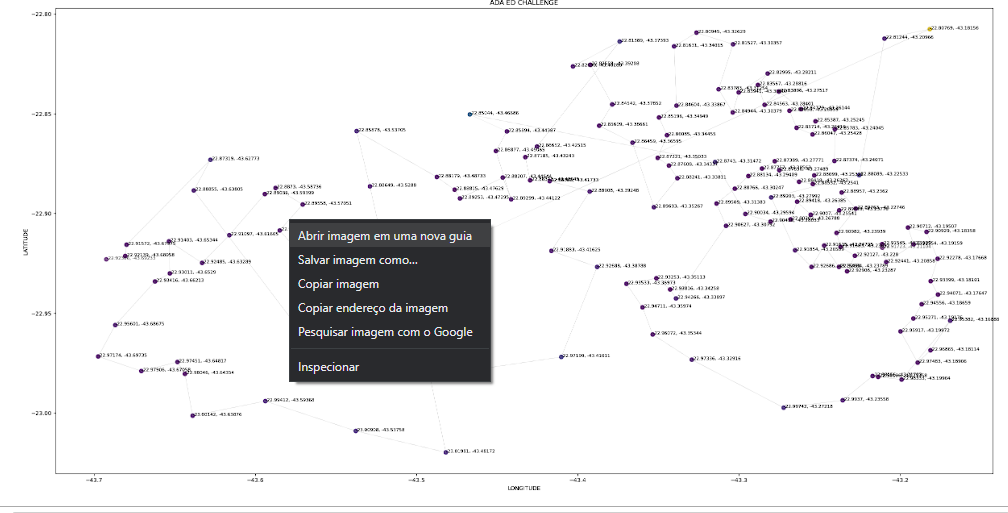